<a href="https://colab.research.google.com/github/UWIZEYEDelphine/enhanced-densenet/blob/main/Densenet%26resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.applications.densenet import DenseNet201
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import os
import matplotlib.pyplot as plt
import random
import cv2
import h5py
from keras.models import load_model

In [ ]:
def create_model(base_model):
  base_model.trainable=False
  model=Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
  model.add(Dense(256, activation='softmax'))


  opt = keras.optimizers.Adam(learning_rate=1e-4)
  met=keras.metrics.TopKCategoricalAccuracy(k=1)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)
  return model

def fit_model(model):
    history = model.fit(training_data, epochs=20, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)
    return history

def plot_history(history):
    acc = history.history['top_k_categorical_accuracy']
    val_acc = history.history['val_top_k_categorical_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(20)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
dir1='/content/delphine/UECF_256_CROP'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.4)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.4)

training_data=gen1.flow_from_directory(dir1, batch_size=32, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=32, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 18939 images belonging to 256 classes.
Found 12456 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
training_data.reset()
x=np.concatenate([training_data.next()[0] for i in range(training_data.__len__())])
y=np.concatenate([training_data.next()[1] for i in range(training_data.__len__())])
print(x.shape)
print(y.shape)

(18939, 300, 300, 3)
(18939, 256)


In [ ]:
validation_data.reset()
x_t=np.concatenate([validation_data.next()[0] for i in range(validation_data.__len__())])
y_t=np.concatenate([validation_data.next()[1] for i in range(validation_data.__len__())])
print(x_t.shape)
print(y_t.shape)

(12456, 300, 300, 3)
(12456, 256)


In [ ]:
base_model1=ResNet152V2(weights='imagenet',include_top=False,input_shape=(300,300,3))
base_model2=DenseNet201(weights='imagenet',include_top=False,input_shape=(300,300,3))

model_1=create_model(base_model1)
model_2=create_model(base_model2)
history1 = fit_model(model_1)
model_1.save('/content/delphine/models/model_1')

history2 = fit_model(model_2)
model_2.save('/content/delphine/models/model_2')

Epoch 1/20
1190/1190 [==============================] - 2024s 2s/step - loss: 5.7865 - top_k_categorical_accuracy: 0.2322 - val_loss: 3.8955 - val_top_k_categorical_accuracy: 0.3745
Epoch 2/20
1190/1190 [==============================] - 2050s 2s/step - loss: 3.3848 - top_k_categorical_accuracy: 0.4240 - val_loss: 3.1977 - val_top_k_categorical_accuracy: 0.4404
Epoch 3/20
1190/1190 [==============================] - 2061s 2s/step - loss: 2.7301 - top_k_categorical_accuracy: 0.4984 - val_loss: 2.8981 - val_top_k_categorical_accuracy: 0.4720
Epoch 4/20
1190/1190 [==============================] - 2067s 2s/step - loss: 2.3543 - top_k_categorical_accuracy: 0.5520 - val_loss: 2.7161 - val_top_k_categorical_accuracy: 0.5022
Epoch 5/20
1190/1190 [==============================] - 1858s 2s/step - loss: 2.1063 - top_k_categorical_accuracy: 0.5887 - val_loss: 2.6478 - val_top_k_categorical_accuracy: 0.5049
Epoch 6/20
1190/1190 [==============================] - 1401s 1s/step - loss: 1.9119 - top

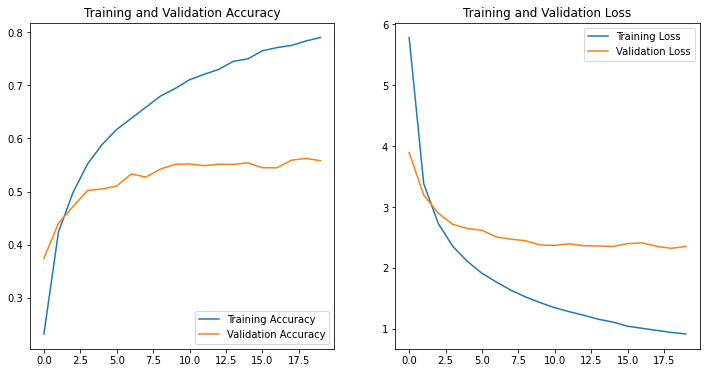

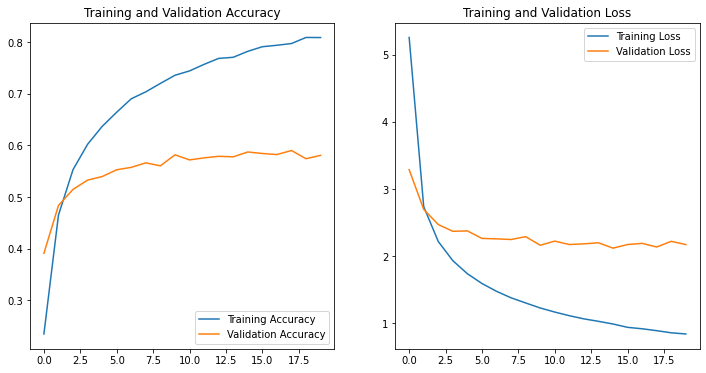

In [ ]:
plot_history(history1)
plot_history(history2)

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['model_1', 'model_2']
    for model_name in model_names:
        filename = os.path.join('/content/delphine/models', model_name)
        model = keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models


In [ ]:
def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge =keras.layers.concatenate(ensemble_outputs)
    merge =keras.layers.Dense(512, activation='relu')(merge)
    output =keras.layers.Dense(256, activation='softmax')(merge)
    model =keras.models.Model(inputs=ensemble_visible, outputs=output)
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    metr=keras.metrics.TopKCategoricalAccuracy(k=1)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=metr)
    return model

In [ ]:
models = load_all_models()


loaded: /content/delphine/models/model_1
loaded: /content/delphine/models/model_2


In [ ]:
model = ensemble_model(models)

In [ ]:
print(model.input)
print(model.output)
print(model.summary())

[<tf.Tensor 'input_1:0' shape=(None, 300, 300, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(None, 300, 300, 3) dtype=float32>]
Tensor("dense_1/Identity:0", shape=(None, 256), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
resnet152v2 (Model)             (None, 10, 10, 2048) 58331648    input_1[0][0]                    
__________________________________________________________________________________________________

In [ ]:
X = [x for _ in range(len(model.input))]
X_1 = [x_t for _ in range(len(model.input))]
history = model.fit(X,y, epochs=20, verbose=1, validation_data=(X_1,y_t),steps_per_epoch=1190, validation_steps=800)

Epoch 1/20
1190/1190 [==============================] - 655s 551ms/step - loss: 5.9179 - top_k_categorical_accuracy: 0.0178 - val_loss: 5.9017 - val_top_k_categorical_accuracy: 0.0227
Epoch 2/20
1189/1190 [============================>.] - ETA: 0s - loss: 5.8732 - top_k_categorical_accuracy: 0.0235

In [ ]:
plot_history(history)

In [ ]:
print('ResNet152V2 acc:', history1.history['val_accuracy'][-1])
print('Densenet acc:', history2.history['val_accuracy'][-1])
print('Ensemble acc:', history.history['val_accuracy'][-1])

resnet for top 5 accuracy

In [ ]:
import keras
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
resnet= ResNet152V2(include_top=False,weights='imagenet',input_shape=(300,300,3))
for layer in resnet.layers:
  layer.trainable=False
model=Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))


opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=5)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)

In [ ]:
dir1='/content/delphine/UECF_256_CROP'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.4)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.4)

training_data=gen1.flow_from_directory(dir1, batch_size=32, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=32, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 18939 images belonging to 256 classes.
Found 12456 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 1266s 1s/step - loss: 5.7942 - top_k_categorical_accuracy: 0.4324 - val_loss: 3.8729 - val_top_k_categorical_accuracy: 0.6470
Epoch 2/40
1190/1190 [==============================] - 1262s 1s/step - loss: 3.3537 - top_k_categorical_accuracy: 0.7000 - val_loss: 3.1494 - val_top_k_categorical_accuracy: 0.7228
Epoch 3/40
1190/1190 [==============================] - 1263s 1s/step - loss: 2.6886 - top_k_categorical_accuracy: 0.7794 - val_loss: 2.8810 - val_top_k_categorical_accuracy: 0.7532
Epoch 4/40
1190/1190 [==============================] - 1262s 1s/step - loss: 2.3496 - top_k_categorical_accuracy: 0.8170 - val_loss: 2.7418 - val_top_k_categorical_accuracy: 0.7704
Epoch 5/40
1190/1190 [==============================] - 1263s 1s/step - loss: 2.0900 - top_k_categorical_accuracy: 0.8469 - val_loss: 2.6636 - val_top_k_categorical_accuracy: 0.7754
Epoch 6/40
1190/1190 [==============================] - 1263s 1s/step - loss: 1.9033 - top

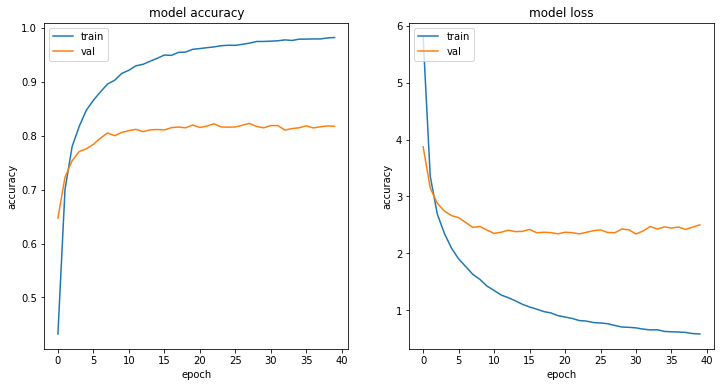

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

resnet top1 for 40 epochs

In [ ]:
import keras
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
resnet= ResNet152V2(include_top=False,weights='imagenet',input_shape=(300,300,3))
for layer in resnet.layers:
  layer.trainable=False
model=Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=1)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)

In [ ]:
dir1='/content/delphine/UECF_256_CROP'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.4)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.4)

training_data=gen1.flow_from_directory(dir1, batch_size=32, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=32, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 18939 images belonging to 256 classes.
Found 12456 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 1264s 1s/step - loss: 5.8145 - top_k_categorical_accuracy: 0.2343 - val_loss: 3.9601 - val_top_k_categorical_accuracy: 0.3734
Epoch 2/40
1190/1190 [==============================] - 1261s 1s/step - loss: 3.3794 - top_k_categorical_accuracy: 0.4248 - val_loss: 3.2339 - val_top_k_categorical_accuracy: 0.4396
Epoch 3/40
1190/1190 [==============================] - 1261s 1s/step - loss: 2.7061 - top_k_categorical_accuracy: 0.5097 - val_loss: 2.9399 - val_top_k_categorical_accuracy: 0.4730
Epoch 4/40
1190/1190 [==============================] - 1261s 1s/step - loss: 2.3438 - top_k_categorical_accuracy: 0.5567 - val_loss: 2.7573 - val_top_k_categorical_accuracy: 0.4966
Epoch 5/40
1190/1190 [==============================] - 1262s 1s/step - loss: 2.1096 - top_k_categorical_accuracy: 0.5890 - val_loss: 2.6493 - val_top_k_categorical_accuracy: 0.5045
Epoch 6/40
1190/1190 [==============================] - 1261s 1s/step - loss: 1.9143 - top

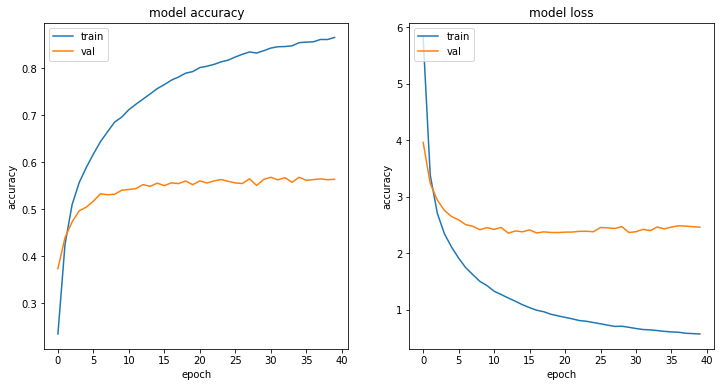

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**uncropped images for resnet top1**






In [ ]:
import keras
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
resnet= ResNet152V2(include_top=False,weights='imagenet',input_shape=(300,300,3))
for layer in resnet.layers:
  layer.trainable=False
model=Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=1)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)

In [ ]:
dir1='/content/delphine/UECF_256'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.3)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.3)

training_data=gen1.flow_from_directory(dir1, batch_size=16, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=16, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 22089 images belonging to 256 classes.
Found 9306 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 685s 576ms/step - loss: 6.9345 - top_k_categorical_accuracy: 0.0986 - val_loss: 5.1845 - val_top_k_categorical_accuracy: 0.2142
Epoch 2/40
1190/1190 [==============================] - 685s 576ms/step - loss: 4.4397 - top_k_categorical_accuracy: 0.2434 - val_loss: 4.0525 - val_top_k_categorical_accuracy: 0.2929
Epoch 3/40
1190/1190 [==============================] - 685s 576ms/step - loss: 3.6053 - top_k_categorical_accuracy: 0.3177 - val_loss: 3.7196 - val_top_k_categorical_accuracy: 0.3370
Epoch 4/40
1190/1190 [==============================] - 689s 579ms/step - loss: 3.1945 - top_k_categorical_accuracy: 0.3663 - val_loss: 3.3969 - val_top_k_categorical_accuracy: 0.3685
Epoch 5/40
1190/1190 [==============================] - 689s 579ms/step - loss: 2.9282 - top_k_categorical_accuracy: 0.4047 - val_loss: 3.2750 - val_top_k_categorical_accuracy: 0.3878
Epoch 6/40
1190/1190 [==============================] - 685s 576ms/step - loss: 

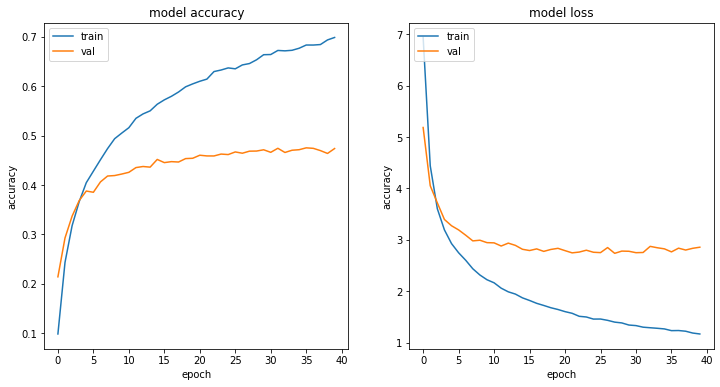

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

resenet top5 for uncropped images

In [ ]:
import keras
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
resnet= ResNet152V2(include_top=False,weights='imagenet',input_shape=(300,300,3))
for layer in resnet.layers:
  layer.trainable=False
model=Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=5)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)

In [ ]:
dir1='/content/delphine/UECF_256'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.3)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.3)

training_data=gen1.flow_from_directory(dir1, batch_size=16, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=16, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 22089 images belonging to 256 classes.
Found 9306 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 695s 584ms/step - loss: 6.8404 - top_k_categorical_accuracy: 0.2663 - val_loss: 5.0949 - val_top_k_categorical_accuracy: 0.4698
Epoch 2/40
1190/1190 [==============================] - 689s 579ms/step - loss: 4.3657 - top_k_categorical_accuracy: 0.5233 - val_loss: 4.0364 - val_top_k_categorical_accuracy: 0.5725
Epoch 3/40
1190/1190 [==============================] - 689s 579ms/step - loss: 3.5807 - top_k_categorical_accuracy: 0.6166 - val_loss: 3.6539 - val_top_k_categorical_accuracy: 0.6199
Epoch 4/40
1190/1190 [==============================] - 687s 577ms/step - loss: 3.1713 - top_k_categorical_accuracy: 0.6738 - val_loss: 3.4595 - val_top_k_categorical_accuracy: 0.6481
Epoch 5/40
1190/1190 [==============================] - 692s 582ms/step - loss: 2.9144 - top_k_categorical_accuracy: 0.7093 - val_loss: 3.3386 - val_top_k_categorical_accuracy: 0.6679
Epoch 6/40
1190/1190 [==============================] - 688s 579ms/step - loss: 

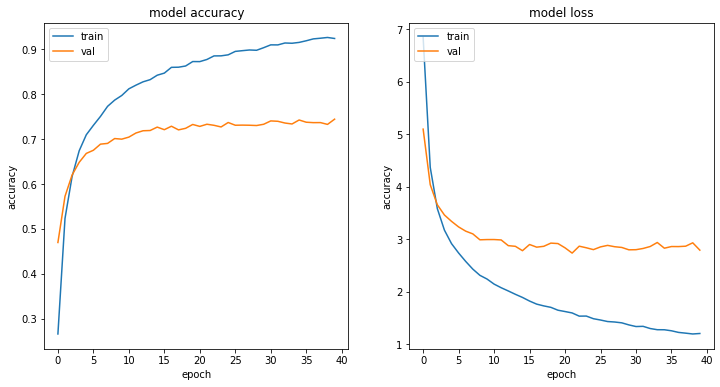

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

densenet fro uncropped images

In [ ]:
import keras
from keras.applications.densenet import DenseNet201
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
densenet=DenseNet201(weights='imagenet',include_top=False,input_shape=(300,300,3))
for layer in densenet.layers[:120]:
  layer.trainable=False
model=Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=5)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)

In [ ]:
dir1='/content/delphine/UECF_256'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.3)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.3)

training_data=gen1.flow_from_directory(dir1, batch_size=16, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=16, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 22089 images belonging to 256 classes.
Found 9306 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 694s 583ms/step - loss: 6.4682 - top_k_categorical_accuracy: 0.2019 - val_loss: 4.5801 - val_top_k_categorical_accuracy: 0.4168
Epoch 2/40
1190/1190 [==============================] - 691s 581ms/step - loss: 3.6881 - top_k_categorical_accuracy: 0.5357 - val_loss: 3.6905 - val_top_k_categorical_accuracy: 0.5990
Epoch 3/40
1190/1190 [==============================] - 690s 580ms/step - loss: 2.7922 - top_k_categorical_accuracy: 0.6893 - val_loss: 3.2695 - val_top_k_categorical_accuracy: 0.6733
Epoch 4/40
1190/1190 [==============================] - 689s 579ms/step - loss: 2.3242 - top_k_categorical_accuracy: 0.7683 - val_loss: 3.1231 - val_top_k_categorical_accuracy: 0.6999
Epoch 5/40
1190/1190 [==============================] - 689s 579ms/step - loss: 2.0343 - top_k_categorical_accuracy: 0.8167 - val_loss: 2.7895 - val_top_k_categorical_accuracy: 0.7632
Epoch 6/40
1190/1190 [==============================] - 688s 578ms/step - loss: 

for top1

In [ ]:
import keras
from keras.applications.densenet import DenseNet201
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten, Conv2D,MaxPool2D, BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random

In [ ]:
densenet=DenseNet201(weights='imagenet',include_top=False,input_shape=(300,300,3))
for layer in densenet.layers[:120]:
  layer.trainable=False
model=Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Dense(256, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
met=keras.metrics.TopKCategoricalAccuracy(k=1)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=met)


In [ ]:
dir1='/content/delphine/UECF_256'

gen1=ImageDataGenerator(rescale= 1./255,width_shift_range=0.3,zoom_range=0.3,height_shift_range=0.2,rotation_range=30,validation_split=0.3)
gen2=ImageDataGenerator(rescale=1./255,validation_split=0.3)

training_data=gen1.flow_from_directory(dir1, batch_size=16, target_size=(300,300),shuffle=True,subset='training')
validation_data=gen2.flow_from_directory(dir1, batch_size=16, target_size=(300,300), subset='validation')
print(training_data.image_shape)

Found 22089 images belonging to 256 classes.
Found 9306 images belonging to 256 classes.
(300, 300, 3)


In [ ]:
history=model.fit(training_data, epochs=40, verbose=1, validation_data=validation_data,steps_per_epoch=1190, validation_steps=800)

Epoch 1/40
1190/1190 [==============================] - 693s 582ms/step - loss: 6.4042 - top_k_categorical_accuracy: 0.0923 - val_loss: 4.8163 - val_top_k_categorical_accuracy: 0.2031
Epoch 2/40
1190/1190 [==============================] - 689s 579ms/step - loss: 3.6236 - top_k_categorical_accuracy: 0.2790 - val_loss: 3.3302 - val_top_k_categorical_accuracy: 0.3552
Epoch 3/40
1190/1190 [==============================] - 687s 578ms/step - loss: 2.7375 - top_k_categorical_accuracy: 0.4034 - val_loss: 3.0462 - val_top_k_categorical_accuracy: 0.4239
Epoch 4/40
1190/1190 [==============================] - 688s 578ms/step - loss: 2.2987 - top_k_categorical_accuracy: 0.4746 - val_loss: 2.9422 - val_top_k_categorical_accuracy: 0.4469
Epoch 5/40
1190/1190 [==============================] - 691s 581ms/step - loss: 2.0202 - top_k_categorical_accuracy: 0.5307 - val_loss: 2.9977 - val_top_k_categorical_accuracy: 0.4668
Epoch 6/40
1190/1190 [==============================] - 693s 582ms/step - loss: 